In [27]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
from sklearn.datasets import fetch_openml

# Read in dataset
data_openml = fetch_openml(data_id=45040)
data = data_openml.data
data["Diagnosis"] = data_openml.target

# Partition the data into train and test sets
print(data)
train = data.loc[data.dataset == "train"]
test = data.loc[data.dataset == "test"]

train = train.drop("dataset", axis=1)
test = test.drop("dataset", axis=1)


# This function formats the data for stacked bar graphs
def grouppivot(labelgroup, yvalue, dataset, SZonly=False):
    # Select only columns with a SZ diagnosis
    if SZonly:
        dataset = dataset.loc[dataset.Diagnosis == 0]

    # Group by label group, and normalize by y value within those groups
    grouped = (
        dataset.groupby([labelgroup])[yvalue]
        .value_counts(normalize=True)
        .rename("percentage")
        .reset_index()
    )

    pivot = pd.pivot_table(
        grouped, index=labelgroup, columns=yvalue, values="percentage", aggfunc="sum"
    )
    return pivot

      dataset     Sex      Race   Housing Delay  Anhedonia   Dep_Mood  \
0       train    Male     Asian    Stable    No   6.859778   8.596433   
1       train    Male  Hispanic    Stable    No   9.833686   8.148029   
2       train  Female     Black  Unstable    No   5.663383   4.076933   
3       train  Female     Black    Stable   Yes   7.265911   6.812793   
4       train    Male     White    Stable   Yes   7.476635   6.901016   
...       ...     ...       ...       ...   ...        ...        ...   
10995    test    Male     Asian    Stable    No   7.146655   8.450431   
10996    test  Female  Hispanic    Stable   Yes   5.100429   7.090143   
10997    test  Female     Asian    Stable    No   6.026583  10.501752   
10998    test    Male     White    Stable    No   9.257268   9.971741   
10999    test  Female     Black    Stable   Yes   8.983786   5.538661   

          Sleep     Tired  Appetite  Rumination  Concentration  Psychomotor  \
0      5.835555  4.249037  4.120215    4.663

In [30]:
train.head()

,Sex,Race,Housing,Delay,Anhedonia,Dep_Mood,Sleep,Tired,Appetite,Rumination,Concentration,Psychomotor,Delusion,Suspicious,Withdrawal,Passive,Tension,Unusual_Thought,Diagnosis
0,Male,Asian,Stable,No,6.859778,8.596433,5.835555,4.249037,4.120215,4.663982,5.112734,2.055298,4.967700,0.339114,4.168202,6.281626,8.124157,1.869677,1.0
1,Male,Hispanic,Stable,No,9.833686,8.148029,4.497432,6.308813,6.270848,5.398494,5.716011,6.071951,2.477303,4.355527,2.559291,4.240824,4.005548,1.069391,0.0
2,Female,Black,Unstable,No,5.663383,4.076933,6.460087,6.918369,3.322668,5.549999,5.797641,5.523801,3.343273,0.725848,4.975947,5.987116,7.064453,4.383587,1.0
3,Female,Black,Stable,Yes,7.265911,6.812793,6.334380,5.264936,3.403835,7.229377,5.897029,4.190843,2.195623,1.535735,4.337831,5.536262,7.429212,0.887562,0.0
4,Male,White,Stable,Yes,7.476635,6.901016,8.782125,5.199603,5.085312,2.251041,10.019488,3.782775,3.251150,5.779466,4.654906,4.517311,6.460591,2.613142,1.0


C:\Users\chand\AppData\Local\Temp\ipykernel_21104\3546839671.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


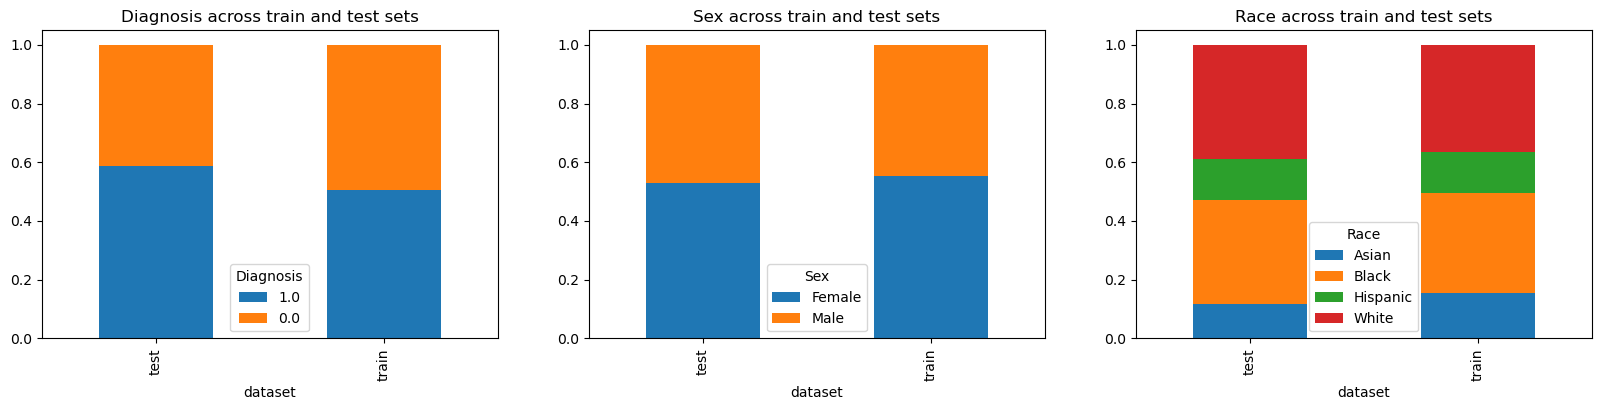

In [31]:
# Format graphs
diagnosis = grouppivot("dataset", "Diagnosis", data)
sex = grouppivot("dataset", "Sex", data)
race = grouppivot("dataset", "Race", data)

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
diagnosis[[1, 0]].plot.bar(stacked=True, ax=axs[0])

axs[0].set_title("Diagnosis across train and test sets")
sex.plot.bar(stacked=True, ax=axs[1])

axs[1].set_title("Sex across train and test sets")
race.plot.bar(stacked=True, ax=axs[2])

axs[2].set_title("Race across train and test sets")
fig.show()

In [32]:
# Split the data into x (features) and y (diagnosis)
trainx = train.drop("Diagnosis", axis=1)
trainy = train.Diagnosis

testx = test.drop("Diagnosis", axis=1)
testy = test.Diagnosis

In [33]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Perform one hot encoding
categories = ["Sex", "Race", "Housing", "Delay"]  # Categorial variables


# Define a function for one hot encoding
def onehot(data, categories=categories):
    ordinalencoder = OneHotEncoder()
    onehot = ordinalencoder.fit_transform(data[categories])

    columns = []
    for i, values in enumerate(ordinalencoder.categories_):
        for j in values:
            columns.append(str(categories[i] + "_" + j))

    return pd.DataFrame(onehot.toarray(), columns=columns)


# Apply transformation to data
trainx = trainx.reset_index(drop=True).join(onehot(trainx))
testx = testx.reset_index(drop=True).join(onehot(testx))

# Drop the original categories
trainx = trainx.drop(categories, axis=1)
testx = testx.drop(categories, axis=1)


In [34]:
# Defining a logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=1)

In [35]:
# Training the model with all available features
model.fit(trainx, trainy)

# generate 10000 predictions for 10000 train individuals
train_predictions = model.predict(trainx)
print("Training accuracy: ", skm.accuracy_score(trainy, train_predictions))  # Training accuracy

# generate 1000 predictions for 1000 test individuals
predictions = model.predict(testx)
print("Test accuracy: ", skm.accuracy_score(testy, predictions))  # Test accuracy

Training accuracy:  0.9306
Test accuracy:  0.938


Sensitivity:  0.9404761904761905 
Specificity:  0.9344660194174758 
PPV:  0.9534482758620689 
NPV:  0.9166666666666666


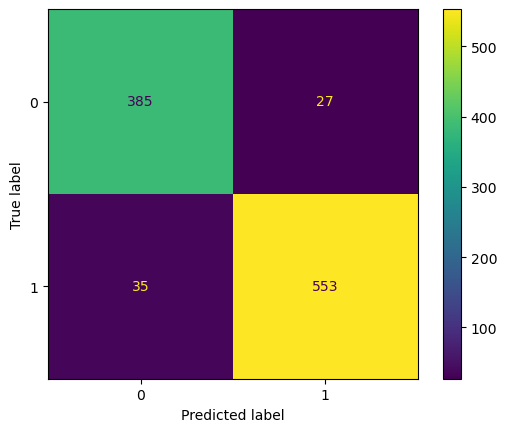

In [36]:
def confusionmatrix(truelabels, predictions):
    confusion_matrix = skm.confusion_matrix(truelabels, predictions)
    tn, fp, fn, tp = confusion_matrix.ravel()
    print(
        "Sensitivity: ",
        tp / (tp + fn),
        "\nSpecificity: ",
        tn / (tn + fp),
        "\nPPV: ",
        tp / (tp + fp),
        "\nNPV: ",
        tn / (tn + fn),
    )

    skm.ConfusionMatrixDisplay(confusion_matrix).plot()


confusionmatrix(testy, predictions)


In [37]:
!pip install fairlearn
from fairlearn.metrics import MetricFrame, false_positive_rate


def f(truelabels, predictions):
    # Define race to be the sensitive variable
    sensitive = test.Race

    # Define a MetricFrame using a FPR of the defined sensitive features, using the true labels and
    # predictions
    fmetrics = MetricFrame(
        metrics=false_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    # Compute the Relative FPR relative to white individuals.
    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White],
        index=["FPR", "Relative FPR"],
    )
    return results


f(testy, predictions)


Race,Asian,Black,Hispanic,White
FPR,0.033898,0.126214,0.057971,0.044199
Relative FPR,0.766949,2.855583,1.311594,1.000000


In [38]:
def intersectionalf(truelabels, predictions):
    # Sensitive features are now the intersection of race and sex
    sensitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis=1), columns=["Race", "Sex"])

    fmetrics = MetricFrame(
        metrics=false_positive_rate,
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    results = pd.DataFrame(
        [fmetrics.by_group, fmetrics.by_group / fmetrics.by_group.White.Male],
        index=["FPR", "Relative FPR"],
    )
    return results


intersectionalf(testy, predictions)

Race          Asian               Black        Hispanic          White  \
Sex          Female      Male    Female  Male    Female Male    Female   
FPR             0.0  0.076923  0.076923  0.28  0.108108  0.0  0.037383   
Relative FPR    0.0  1.423077  1.423077  5.18  2.000000  0.0  0.691589   

Race                    
Sex               Male  
FPR           0.054054  
Relative FPR  1.000000

In [39]:
race_cat = ["Race_Asian", "Race_Black", "Race_Hispanic", "Race_White"]
trainx_norace = trainx.drop(race_cat, axis=1)
testx_norace = testx.drop(race_cat, axis=1)

In [40]:
# Define and train a second model
model2 = LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=1)
model2 = model2.fit(trainx_norace, trainy)

train_predictions = model2.predict(trainx_norace)
print("Training accuracy: ", skm.accuracy_score(trainy, train_predictions))  # Training accuracy

predictions = model2.predict(testx_norace)
print("Test accuracy: ", skm.accuracy_score(testy, predictions))  # Test accuracy

Training accuracy:  0.9297
Test accuracy:  0.937


In [41]:
f(testy, predictions)

Race,Asian,Black,Hispanic,White
FPR,0.067797,0.126214,0.057971,0.033149
Relative FPR,2.045198,3.807443,1.748792,1.000000


In [42]:
intersectionalf(testy, predictions)

Race             Asian               Black            Hispanic          White  \
Sex             Female      Male    Female      Male    Female Male    Female   
FPR           0.030303  0.115385  0.076923  0.280000  0.108108  0.0  0.028037   
Relative FPR  0.747475  2.846154  1.897436  6.906667  2.666667  0.0  0.691589   

Race                    
Sex               Male  
FPR           0.040541  
Relative FPR  1.000000

In [44]:
#TPR
from fairlearn.metrics import true_positive_rate

def intersectional_metrics(truelabels, predictions):
    # Sensitive features are the intersection of race and sex
    sensitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis=1), columns=["Race", "Sex"])

    # Define a MetricFrame for FPR and TPR using the true labels, predictions, and sensitive features
    metrics = MetricFrame(
        metrics={"FPR": false_positive_rate, "TPR": true_positive_rate},
        y_true=truelabels,
        y_pred=predictions,
        sensitive_features=sensitive,
    )

    # Compute the relative metrics using White Men as the reference group
    fpr_results = pd.DataFrame(
        [metrics.by_group["FPR"], metrics.by_group["FPR"] / metrics.by_group["FPR"].White.Male],
        index=["FPR", "Relative FPR"],
    )

    tpr_results = pd.DataFrame(
        [metrics.by_group["TPR"], metrics.by_group["TPR"] / metrics.by_group["TPR"].White.Male],
        index=["TPR", "Relative TPR"],
    )

    return fpr_results, tpr_results

In [45]:
fpr_results, tpr_results = intersectional_metrics(testy, predictions)
print("False Positive Rate:")
print(fpr_results)
print("\nTrue Positive Rate:")
print(tpr_results)

False Positive Rate:
Race             Asian               Black            Hispanic          White  \
Sex             Female      Male    Female      Male    Female Male    Female   
FPR           0.030303  0.115385  0.076923  0.280000  0.108108  0.0  0.028037   
Relative FPR  0.747475  2.846154  1.897436  6.906667  2.666667  0.0  0.691589   

Race                    
Sex               Male  
FPR           0.040541  
Relative FPR  1.000000  

True Positive Rate:
Race             Asian               Black            Hispanic            \
Sex             Female      Male    Female      Male    Female      Male   
TPR           0.892857  0.928571  0.942529  0.982036  0.916667  0.914286   
Relative TPR  0.960669  0.999096  1.014113  1.056621  0.986287  0.983725   

Race             White            
Sex             Female      Male  
TPR           0.909836  0.929412  
Relative TPR  0.978938  1.000000  
